# Data Loading
Before beginning with the task, let's import the dataset that is going to be used along this module. This dataset was explored in the module before.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from functions import (
    three_way_split_time,
    logit_significance,
    get_best_treshold,
    print_metrics,
    plot_auc_pr_curve,
    pick_features_for_splits
)

In [2]:
plt.style.use('ggplot')

In [3]:
df = pd.read_csv('../../data/module2/feature_frame.csv')
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


> We are only interested in users that purchases the item along with at least other 4 (minimum 5 items basket), since shipping costs for a single or few items can be higher than the gross margin coming from it.

In [4]:
ordered = df[df['outcome'] == 1] # have been ordered
orders_len = ordered.groupby('order_id').outcome.sum() 
orders_selection = orders_len[orders_len >= 5].index
df2 = df[df['order_id'].isin(orders_selection)]

In [5]:
df['order_id'].nunique() > df2['order_id'].nunique()

True

In [6]:
df2.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')

In [7]:
info_cols = ['variant_id', 'order_id', 'user_id', 'order_date', 'created_at']
label_cols = ['outcome']
features_cols = [col for col in df2.columns if col not in info_cols + label_cols]
categorical_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = [col for col in features_cols if col not in categorical_cols + binary_cols]

In [8]:
df2['order_date'] = pd.to_datetime(df2['order_date']).dt.date
df2['created_at'] = pd.to_datetime(df2['created_at'])

/var/folders/9s/g205zh4n1qxctfk8d568b41c0000gn/T/ipykernel_3756/644260562.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['order_date'] = pd.to_datetime(df2['order_date']).dt.date
/var/folders/9s/g205zh4n1qxctfk8d568b41c0000gn/T/ipykernel_3756/644260562.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['created_at'] = pd.to_datetime(df2['created_at'])


In [9]:
X = df2[features_cols+info_cols]
Y = df2[label_cols]

<Axes: xlabel='order_date'>

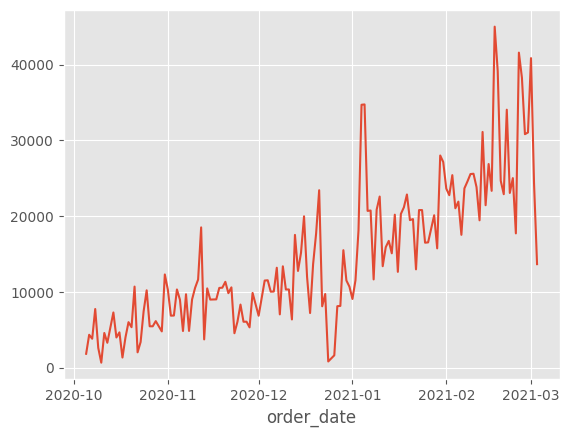

In [10]:
X = X.sort_values('order_date')
    
# Reorganizar Y basado en el índice de X
Y = Y.loc[X.index]

# Agrupar por fecha y obtener el acumulado de órdenes
daily_orders = X.groupby('order_date').size()
cumsum_daily_orders = daily_orders.cumsum() / daily_orders.sum()
daily_orders.plot()

<Axes: xlabel='order_date'>

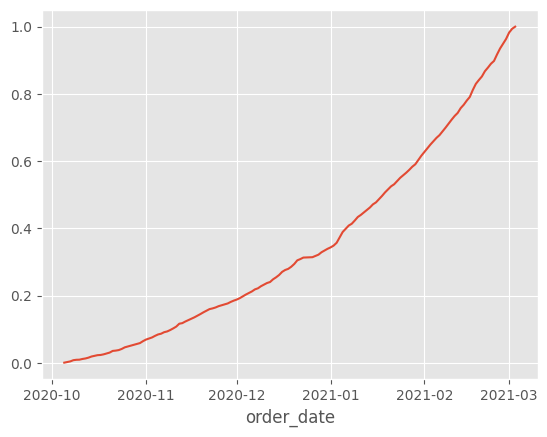

In [11]:
cumsum_daily_orders.plot()

In [12]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = three_way_split_time(X, Y)
X_train.tail()

,product_type,user_order_seq,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,...,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,variant_id,order_id,user_id,order_date,created_at
1526851,pickledfoodolives,2,0.0,0.0,0.0,0.0,0.056655,0.076555,kühne,0.003888,...,32.0,23.781019,30.0,30.0,25.477284,34368926449796,2916537696388,3882518708356,2021-02-07,2021-02-07 17:08:35
2835008,floorcleanerpolish,4,0.0,0.0,0.0,0.0,0.032258,0.084034,mrsheen,0.000000,...,71.5,36.224678,13.0,38.5,31.832738,34284951339140,2916421664900,3900863086724,2021-02-07,2021-02-07 14:29:53
1526852,pickledfoodolives,2,0.0,0.0,0.0,0.0,0.056655,0.076555,kühne,0.003888,...,32.0,23.781019,30.0,30.0,25.477284,34368926449796,2916544610436,3879696957572,2021-02-07,2021-02-07 17:19:45
2332235,longlifemilksubstitutes,5,0.0,0.0,0.0,0.0,0.056655,0.100478,daioni,0.000000,...,58.0,20.041623,30.0,25.0,21.048990,34137391300740,2916497916036,3490195374212,2021-02-07,2021-02-07 16:02:27
2835010,floorcleanerpolish,5,0.0,0.0,0.0,0.0,0.032258,0.084034,mrsheen,0.000000,...,71.5,36.224678,62.0,38.5,31.832738,34284951339140,2916497916036,3490195374212,2021-02-07,2021-02-07 16:02:27


In [13]:
X_val.head()

,product_type,user_order_seq,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,...,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,variant_id,order_id,user_id,order_date,created_at
1101764,allpurposecleaner,2,0.0,0.0,0.0,0.0,0.203036,0.335113,flashpgp,0.002370,...,54.0,34.910030,30.0,36.0,28.268085,34086450987140,2917253709956,3875434168452,2021-02-08,2021-02-08 16:59:52
1101763,allpurposecleaner,3,0.0,0.0,0.0,0.0,0.203036,0.335113,flashpgp,0.002370,...,54.0,34.910030,30.0,36.0,28.268085,34086450987140,2917231329412,3866302775428,2021-02-08,2021-02-08 16:23:17
446105,babytoiletries,5,0.0,0.0,0.0,0.0,0.072919,0.412639,huggies,0.006319,...,32.5,28.398241,30.0,36.0,29.372186,34037940158596,2917315281028,3769633964164,2021-02-08,2021-02-08 17:59:00
1101765,allpurposecleaner,2,0.0,0.0,0.0,0.0,0.203036,0.335113,flashpgp,0.002370,...,54.0,34.910030,30.0,36.0,28.268085,34086450987140,2917290934404,3900532162692,2021-02-08,2021-02-08 17:34:45
1101761,allpurposecleaner,17,0.0,0.0,0.0,0.0,0.203036,0.335113,flashpgp,0.002370,...,54.0,34.910030,94.0,36.0,28.268085,34086450987140,2917213208708,3461371953284,2021-02-08,2021-02-08 15:53:46


In [14]:
Y_train.tail()

1526851    0.0
2835008    0.0
1526852    0.0
2332235    0.0
2835010    0.0
Name: outcome, dtype: float64

In [15]:
Y_val.head()

1101764    0.0
1101763    0.0
446105     0.0
1101765    0.0
1101761    0.0
Name: outcome, dtype: float64

In [16]:
classes = Y.value_counts()
total = classes[0] + classes[1]
# proportion of classes
print(f'class 0: {classes[0]/total}')
print(f'class 1: {classes[1]/total}')

class 0: 0.9855223288121322
class 1: 0.014477671187867759


# Baseline Model
We are going to build a first baseline model with `global_popularity`as feature

In [17]:
TARGET = 'outcome'
features = ['global_popularity']

In [18]:
x_train, x_val, x_test = pick_features_for_splits(X_train, X_val, X_test, features)

In [19]:
logit_results = logit_significance(x_train, Y_train)
print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.074449
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1489664
Model:                          Logit   Df Residuals:                  1489662
Method:                           MLE   Df Model:                            1
Date:                Wed, 23 Oct 2024   Pseudo R-squ.:                 0.04478
Time:                        19:30:20   Log-Likelihood:            -1.1090e+05
converged:                       True   LL-Null:                   -1.1610e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.4923      0.008   -567.564      0.000      -4.508      -4.477
global_p

In [20]:
model = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)
model.fit(x_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [ ]:
y_val_pred_prob = model.predict_proba(x_val)[:,1]

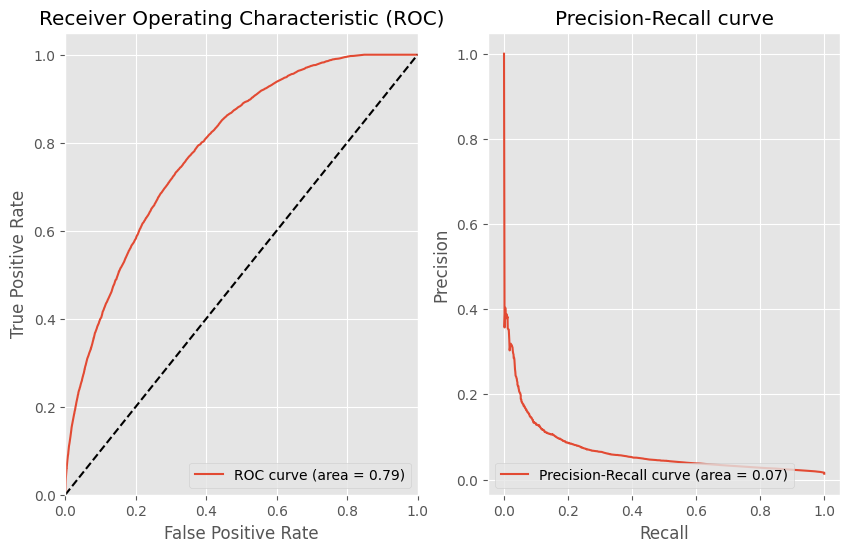

In [22]:
plot_auc_pr_curve(Y_val, y_val_pred_prob)

In [23]:
best_threshold = get_best_treshold(Y_val, y_val_pred_prob)
y_val_pred = np.array([1 if p > best_threshold else 0 for p in y_val_pred_prob])

In [24]:
print_metrics(Y_val, y_val_pred)

Accuracy: 0.97122345075383
Confusion Matrix:
 [[422409   7511]
 [  5031    890]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    429920
         1.0       0.11      0.15      0.12      5921

    accuracy                           0.97    435841
   macro avg       0.55      0.57      0.55    435841
weighted avg       0.98      0.97      0.97    435841



# Modeling

In [42]:
features = numerical_cols + binary_cols
x_train, x_val, x_test = pick_features_for_splits(X_train, X_val, X_test, features)

In [43]:
model = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

model.fit(x_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [44]:
y_val_pred_prob = model.predict_proba(x_val)[:,1]

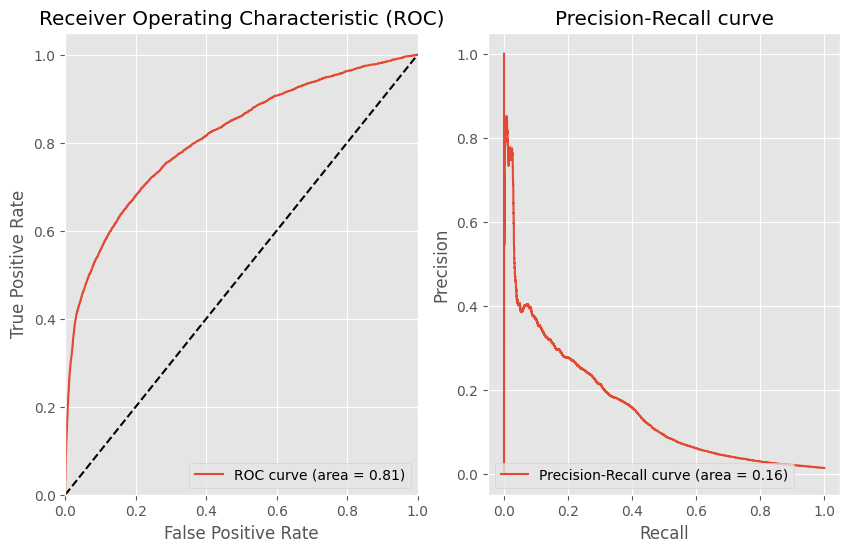

In [45]:
plot_auc_pr_curve(Y_val, y_val_pred_prob)

In [46]:
best_threshold = get_best_treshold(Y_val, y_val_pred_prob)
y_val_pred = np.array([1 if p > best_threshold else 0 for p in y_val_pred_prob])
print_metrics(Y_val, y_val_pred)

/Users/laiqiands/GitHub/zrive-ds/src/module_3/functions.py:59: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Accuracy: 0.9864147705241132
Confusion Matrix:
 [[429920      0]
 [  5921      0]]


/Users/laiqiands/Library/Caches/pypoetry/virtualenvs/zrive-ds-Rss0z1WZ-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/laiqiands/Library/Caches/pypoetry/virtualenvs/zrive-ds-Rss0z1WZ-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    429920
         1.0       0.00      0.00      0.00      5921

    accuracy                           0.99    435841
   macro avg       0.49      0.50      0.50    435841
weighted avg       0.97      0.99      0.98    435841



/Users/laiqiands/Library/Caches/pypoetry/virtualenvs/zrive-ds-Rss0z1WZ-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [49]:
logit_results = logit_significance(x_train, Y_train)
print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.066112
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1489664
Model:                          Logit   Df Residuals:                  1489644
Method:                           MLE   Df Model:                           19
Date:                Wed, 23 Oct 2024   Pseudo R-squ.:                  0.1517
Time:                        19:44:05   Log-Likelihood:                -98485.
converged:                       True   LL-Null:                   -1.1610e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -3.6337      0.100    -36.49

In [50]:
print(logit_results.pvalues[logit_results.pvalues < 0.05])

const                               1.187797e-291
user_order_seq                       2.450901e-42
normalised_price                    5.981898e-217
discount_pct                         1.185294e-03
global_popularity                    0.000000e+00
count_pets                           1.402015e-04
days_since_purchase_variant_id       1.481628e-05
avg_days_to_buy_variant_id           9.106819e-49
days_since_purchase_product_type     8.735086e-25
avg_days_to_buy_product_type         2.728448e-06
ordered_before                       0.000000e+00
abandoned_before                     0.000000e+00
active_snoozed                       3.035747e-03
set_as_regular                       1.006868e-93
dtype: float64


In [56]:
logit_results.pvalues[logit_results.pvalues < 0.05].sort_values()

global_popularity                    0.000000e+00
ordered_before                       0.000000e+00
abandoned_before                     0.000000e+00
const                               1.187797e-291
normalised_price                    5.981898e-217
set_as_regular                       1.006868e-93
avg_days_to_buy_variant_id           9.106819e-49
user_order_seq                       2.450901e-42
days_since_purchase_product_type     8.735086e-25
avg_days_to_buy_product_type         2.728448e-06
days_since_purchase_variant_id       1.481628e-05
count_pets                           1.402015e-04
discount_pct                         1.185294e-03
active_snoozed                       3.035747e-03
dtype: float64

In [60]:
selected_features = logit_results.pvalues[logit_results.pvalues < 0.05].sort_values().index[:3]
list(selected_features)

['global_popularity', 'ordered_before', 'abandoned_before']

In [61]:
x_train, x_val, x_test = pick_features_for_splits(X_train, X_val, X_test, list(selected_features))


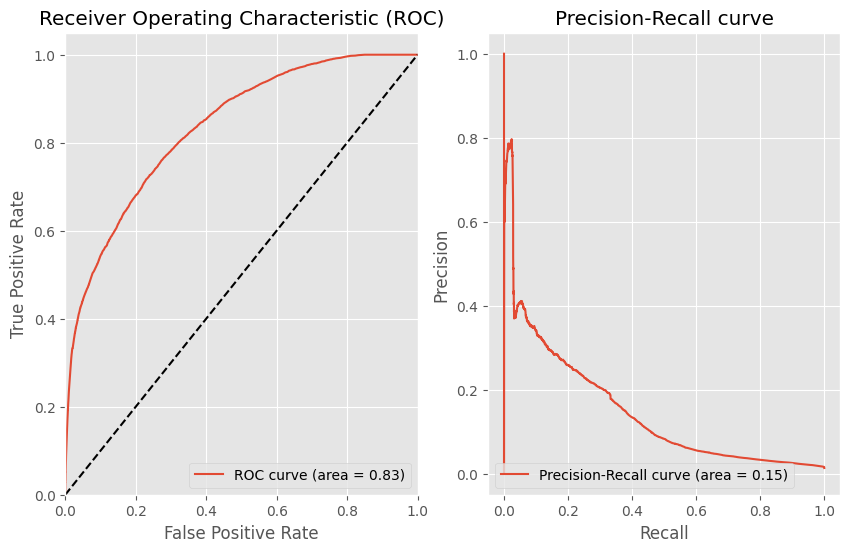

In [62]:
model = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

model.fit(x_train, Y_train)
y_val_pred_prob = model.predict_proba(x_val)[:,1]
plot_auc_pr_curve(Y_val, y_val_pred_prob)

In [63]:
best_threshold = get_best_treshold(Y_val, y_val_pred_prob)
y_val_pred = np.array([1 if p > best_threshold else 0 for p in y_val_pred_prob])
print_metrics(Y_val, y_val_pred)

/Users/laiqiands/GitHub/zrive-ds/src/module_3/functions.py:59: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Accuracy: 0.9864147705241132
Confusion Matrix:
 [[429920      0]
 [  5921      0]]


/Users/laiqiands/Library/Caches/pypoetry/virtualenvs/zrive-ds-Rss0z1WZ-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/laiqiands/Library/Caches/pypoetry/virtualenvs/zrive-ds-Rss0z1WZ-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    429920
         1.0       0.00      0.00      0.00      5921

    accuracy                           0.99    435841
   macro avg       0.49      0.50      0.50    435841
weighted avg       0.97      0.99      0.98    435841



/Users/laiqiands/Library/Caches/pypoetry/virtualenvs/zrive-ds-Rss0z1WZ-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [64]:
logit_results = logit_significance(x_train, Y_train)
print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.066889
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1489664
Model:                          Logit   Df Residuals:                  1489660
Method:                           MLE   Df Model:                            3
Date:                Wed, 23 Oct 2024   Pseudo R-squ.:                  0.1418
Time:                        19:48:31   Log-Likelihood:                -99642.
converged:                       True   LL-Null:                   -1.1610e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.7606      0.009   -534.554      0.000      -4.778      -4.743
global_p